In [1]:
import torch as th
from torch.utils.data import Dataset
import pandas as pd
import os
import numpy as np
import ffmpeg
import math
import csv
import time
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import json

In [2]:
def _get_output_dim(size, h, w):
    if isinstance(size, tuple) and len(size) == 2:
        return size
    elif h >= w:
        return int(h * size / w), size
    else:
        return size, int(w * size / h)

def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        try:
            num, denom = frac_str.split('/')
        except ValueError:
            return None
        try:
            leading, num = num.split(' ')
        except ValueError:
            return float(num) / float(denom)
        if float(leading) < 0:
            sign_mult = -1
        else:
            sign_mult = 1
        return float(leading) + sign_mult * (float(num) / float(denom))
def _get_video_info(video_path):
    probe = ffmpeg.probe(video_path)
    video_stream = next((stream for stream in probe['streams']
                            if stream['codec_type'] == 'video'), None)
    width = int(video_stream['width'])
    height = int(video_stream['height'])
    fps = math.floor(convert_to_float(video_stream['avg_frame_rate']))
    try:
        frames_length = int(video_stream['nb_frames'])
        duration = float(video_stream['duration'])
    except Exception:
        frames_length, duration = -1, -1
    info = {"duration": duration, "frames_length": frames_length,
            "fps": fps, "height": height, "width": width}
    return info

In [3]:
downloaded_fn = glob.glob("/saltpool0/data/pyp/vqhighlight/video/*.mkv")
# hs = []
# ws = []
# for video_path in tqdm.tqdm(downloaded_fn):
#     info = _get_video_info(video_path)
#     h, w = info["height"], info["width"]
#     hs.append(h)
#     ws.append(w)
# plt.figure()
# sns.histplot(hs)
# plt.figure()
# sns.histplot(ws)

100%|██████████| 442/442 [00:15<00:00, 28.24it/s]


<AxesSubplot:ylabel='Count'>

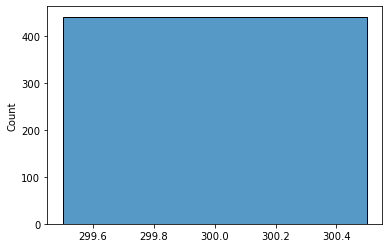

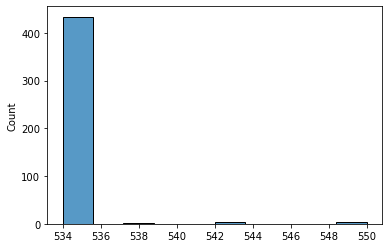

In [15]:
downloaded_fn2 = glob.glob("/saltpool0/data/pyp/vqhighlight/video/*.mp4")
hs2 = []
ws2 = []
for video_path in tqdm.tqdm(downloaded_fn2):
    info = _get_video_info(video_path)
    h, w = info["height"], info["width"]
    hs2.append(h)
    ws2.append(w)
plt.figure()
sns.histplot(hs2)
plt.figure()
sns.histplot(ws2)

In [16]:
300/534

0.5617977528089888

In [28]:
720/(300/534)

1281.6

In [19]:
# so for mp4, videos are all 300 * 534
# for mkv, videos are mostly 720 * 1280
overwrite = True
framerate = 1
size = 256
centercrop = False
video_path = downloaded_fn[1000]
load_flag = os.path.isfile(video_path)

if load_flag:
    # print('Decoding video: {}'.format(video_path))
    try:
        info = _get_video_info(video_path)
        h, w = info["height"], info["width"]
        print(f"original video size: {h}x{w}")
    except Exception:
        print('ffprobe failed at: {}'.format(video_path))
        # return {'video': th.zeros(1), 'input': video_path,
        #         'output': output_file, 'info': {}}
    height, width = _get_output_dim(size, h, w)
    print(f"scale the video to {height}x{width}")
    try:
        duration = info["duration"]
        fps = framerate
        if duration > 0 and duration < 1/fps+0.1:
            fps = 2/max(int(duration), 1)
            print(duration, fps)
    except Exception:
        fps = framerate
    all_video = []
    all_len = []
    cmd = (
            ffmpeg
            .input(video_path)
            .filter('fps', fps=fps)
            .filter('scale', width, height)
            )
    if centercrop:
        x = int((width - size) / 2.0)
        y = int((height - size) / 2.0)
        cmd = cmd.crop(x, y, size, size)
        print(f"x: {x}, y:{y}, size: {size}")
    s_time = time.time()
    out_fn = "./test"
    out, _ = (
        # cmd.output('pipe:', format='rawvideo', pix_fmt='rgb24')
        cmd.output(out_fn+'/'+'test-%d.jpg', start_number=0)
        .overwrite_output()
        .run(capture_stdout=True, quiet=True)
    )
    # print(f"ffmpeg time: {time.time() - s_time:.4f}")
    if centercrop and isinstance(size, int):
        height, width = size, size
    video = np.frombuffer(out, np.uint8).reshape(
        [-1, height, width, 3])
    # T, H, W, C = video.shape
    # video = th.IntTensor(video)
    # video = video.permute(0, 3, 1, 2).numpy() # T, C, H, W
    video = video.transpose((0, 3, 1, 2))
        # print(f"final video frame size: {video.shape[-2]}x{video.shape[-1]}")
    # np.savez_compressed("temp.npz", **{"video": video})
    print(f"final video frame size: {video.shape[-2]}x{video.shape[-1]}")

original video size: 720x1280
scale the video to 256x455
final video frame size: 256x455


In [20]:
time_s = time.time()
for _ in range(10):
    _ = dict(np.load("temp.npz"))['video']
print(time.time() - time_s)

2.711531162261963


In [18]:
time_s = time.time()
for _ in range(10):
    _ = np.load("temp.npy")
print(time.time() - time_s)

0.23798441886901855


In [16]:
import cv2
from PIL import Image
time_s = time.time()
for _ in range(10):
    for i in range(150):
        # image = np.array(Image.open(f"test-{i}.jpg"))
        image = cv2.imread(f"test-{i}.jpg")
print(time.time() - time_s)

1.6146492958068848


In [14]:
np.array(image).shape

(256, 455, 3)

In [18]:
image.shape

(256, 455, 3)

full cound:  1550
total zero neg instance:  52
total instances:  1550


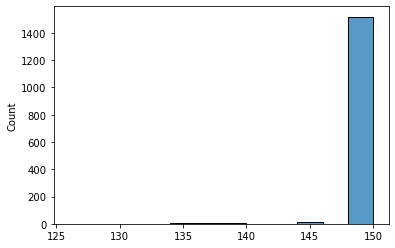

In [9]:
def load_jsonl(filename):
    with open(filename, "r") as f:
        return [json.loads(l.strip("\n")) for l in f.readlines()]
data = load_jsonl("/home/pyp/vqhighlight/data/highlight_val_release.jsonl")
positive_ranges = [] # in frames (int)
negative_ranges = [] # in frames (int)
time_s = time.time()
total_count = []
zero_count = 0
full_count = 0
for item in data:
    vid = item['vid']
    image_files = glob.glob(os.path.join("/saltpool0/data/pyp/vqhighlight/image", "framerate1", vid, "*.jpg"))
    total_range = list(range(len(image_files)))
    if len(total_range) > 100:
        full_count += 1

    # print("total images: ", len(total_range))
    total_count.append(len(total_range))
    positive_range = []
    for s,e in item['relevant_windows']:
        positive_range += list(range(int(s), int(e)))
    # print("positive images", len(positive_range))
    positive_ranges.append(positive_range)
    negative_range = list(set(total_range).difference(set(positive_range)))
    # print("negative images", len(negative_range))
    if len(negative_range) == 0:
        zero_count += 1
    negative_ranges.append(negative_range)
plt.figure()
sns.histplot(total_count)
# plt.savefig("total_count.jpg")
print("full cound: ", full_count)
print("total zero neg instance: ", zero_count)
print("total instances: ", len(total_count))

full cound:  1550
total instances:  1550


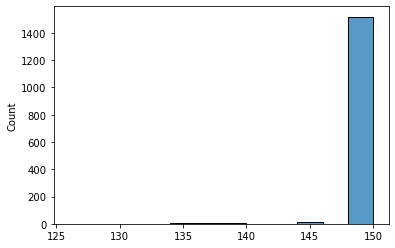

In [3]:
def load_jsonl(filename):
    with open(filename, "r") as f:
        return [json.loads(l.strip("\n")) for l in f.readlines()]
data = load_jsonl("/home/pyp/vqhighlight/data/highlight_val_release.jsonl")
positive_ranges = [] # in frames (int)
negative_ranges = [] # in frames (int)
time_s = time.time()
total_count = []
zero_count = 0
full_count = 0
for item in data:
    vid = item['vid']
    image_files = glob.glob(os.path.join("/saltpool0/data/pyp/vqhighlight/image", "framerate1", vid, "*.jpg"))
    total_range = list(range(len(image_files)))
    if len(total_range) > 100:
        full_count += 1

    # print("total images: ", len(total_range))
    total_count.append(len(total_range))
    positive_range = []
    # for s,e in item['relevant_windows']:
    #     positive_range += list(range(int(s), int(e)))
    # # print("positive images", len(positive_range))
    # positive_ranges.append(positive_range)
    # negative_range = list(set(total_range).difference(set(positive_range)))
    # # print("negative images", len(negative_range))
    # if len(negative_range) == 0:
    #     zero_count += 1
    # negative_ranges.append(negative_range)
plt.figure()
sns.histplot(total_count)
# plt.savefig("total_count.jpg")
print("full cound: ", full_count)
# print("total zero neg instance: ", zero_count)
print("total instances: ", len(total_count))